# Examining Healthcare Charges in the United States: A look at Medicare
---

By: Maimuna Lubega

## Table of Contents

1. [Data Pre-processing](#sec1)
    - 1.1 [Table 1:Inpatient Charge Data Fiscal Year  2015](#sec2)
    - 1.2 [Table 2: Health Insurance Coverage Status and Type of Coverage by State](#sec3)
2. [Exploratory Data Analysis](#sec4)
    - 2.1 [Most Common Procedure: Septicemia/Sepsis](#sec5)
    - 2.2 [Most Expensive Procedures: Transplants & LIfe Support](#sec6)
    - 2.3 [Most Costly States: California, Nevada, New Jersey, Alaska, Colorado](#sec7)
    - 2.4 [Charges v. Payments: Missing Money](#sec8)
    - 2.5 [Percent of People on Medicare by State: 11 - 22%](#sec9)
3. [Modeling and Analysis](#sec10)
    - 3.1 [KMeans Clustering on DRG's](#sec11)
    - 3.2 [Assessing Correlation: Percent on Medicare and Average Charges by State](#sec12)
    - 3.3 [KMeans Clustering on US States](#sec13)
4. [Reflections](#sec14)
5. [References](#sec15)


<a id="sec1"></a>


##  1. Data Pre-processing

---

In [42]:
import csv as csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
import time
import statsmodels.api as smdl
import pprint as pp

from math import pi
from numpy import histogram
from numpy import histogram
from bokeh.layouts import row, column
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from sklearn import metrics
from scipy import stats
from scipy.cluster.vq import kmeans,vq
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

output_notebook()

Loading BokehJS ...

<a id="sec2"></a>

### Table 1 :  Inpatient Charge Data Fiscal Year  2015
---

The first data file is published by the Centers for Medicare and Medicaid Services (CMS) \[1\]. Each observation represents the averaged costs and payments for one DRG (Diagnosis Related Group) at a particular health care provider in 2015. There are 563 unique DRG Definitions, 3231 unique healthcare providers across 50 states. The charges and payments are averaged over the number of discharges (cases), and Average Medicare Payment is a subset of the Average Total Payment. \[2\]\[3\]

In [43]:
#First Data File - Medicare DRGS/ Charges/Payments

INPATIENT_DATA_FILE_2015 = 'Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv'
STATE_NAME_ABV_FILE = 'states_hash.json'

#read files
inpatient_charges = pd.read_csv(INPATIENT_DATA_FILE_2015)
state_mapper = pd.read_json(STATE_NAME_ABV_FILE, typ='series')

# drop some columns 
not_needed = ['Provider Street Address', 'Hospital Referral Region (HRR) Description', 'Provider Name']
inpatient_charges = inpatient_charges.drop(not_needed, axis=1)

# File only has state abbreviations, add full state name to dataframe
state_abvs = inpatient_charges['Provider State']
inpatient_charges['State'] = state_abvs.map(state_mapper)

cols, rows = inpatient_charges.shape

print("Columns: ", str(cols), "/ Rows:", str(rows))
inpatient_charges.head()

Columns:  201876 / Rows: 10


,DRG Definition,Provider Id,Provider City,Provider State,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,State
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,BIRMINGHAM,AL,35233,11,1014783.45,171081.18,141193.91,Alabama
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,PHOENIX,AZ,85054,28,382051.00,194081.39,167511.96,Arizona
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50025,SAN DIEGO,CA,92103,21,971881.48,324050.71,294419.62,California
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50100,SAN DIEGO,CA,92123,18,1517857.61,257177.33,233532.83,California
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,SACRAMENTO,CA,95816,17,1470341.06,346150.12,338472.00,California


In [44]:
#some brief stats

print("Number of DRGs: ", len(inpatient_charges['DRG Definition'].unique()))
print("Number of Providers: ", len(inpatient_charges['Provider Id'].unique()))
print("Max Av Charges: ", inpatient_charges['Average Covered Charges'].max(), 
      "-- Min Av Charges: ",inpatient_charges['Average Covered Charges'].min() )
print("Max Av Payments: ", inpatient_charges['Average Total Payments'].max(), 
      "-- Min Av Payments: ",inpatient_charges['Average Total Payments'].min() )


Number of DRGs:  563
Number of Providers:  3231
Max Av Charges:  2794183.75 -- Min Av Charges:  1715.0
Max Av Payments:  449486.11 -- Min Av Payments:  2419.49


In [45]:
# Florida, California, Texas, and New York have most entries
# Hawaii, Vermont, Wyoming, and Alaska have the least
# since we will average over num of discharges, it should not be a problem
inpatient_charges['Provider State'].value_counts()

FL    15371
CA    15113
TX    14171
NY    11257
PA     9586
IL     9128
OH     7917
MI     7540
NJ     6693
NC     6427
GA     5691
VA     5677
MA     5288
IN     5123
TN     5122
MO     5040
MD     4708
AL     4310
KY     3763
SC     3555
WA     3472
AZ     3453
MN     3335
WI     3310
LA     3297
OK     2967
MS     2753
AR     2523
CT     2517
CO     2272
IA     2130
KS     2101
WV     1693
OR     1658
NV     1512
NE     1360
NH     1032
ME     1010
UT      981
NM      939
DC      740
RI      728
DE      707
ID      689
SD      677
MT      617
ND      604
HI      444
VT      345
WY      267
AK      263
Name: Provider State, dtype: int64

In [46]:
##  Grouping Data by DRG & by State for analysis and eventual clustering

# To avoid aggregrating the mean of means, first recover total sum of charges/payments for each row
inpatient_charges['Total Charges'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Covered Charges']
inpatient_charges['Total Payments'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Total Payments']
inpatient_charges['Total Medicare Payments'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Medicare Payments']



#group by DRG, take sums
by_drg = inpatient_charges.groupby(['DRG Definition']).agg({ 'Total Discharges':'sum',
                                                             'Total Charges': 'sum',
                                                             'Total Payments':'sum',
                                                             'Total Medicare Payments': 'sum' })

#calcuate new averages
by_drg['Average Charges'] = by_drg['Total Charges']/by_drg['Total Discharges']
by_drg['Average Payments'] = by_drg['Total Payments']/by_drg['Total Discharges']
by_drg['Average Medicare Payment'] = by_drg['Total Medicare Payments']/by_drg['Total Discharges']

by_drg = by_drg.sort_values(by='Average Charges', ascending=False)


# group by state, take sums
by_state = inpatient_charges.groupby(['State']).agg({ 'Total Discharges':'sum',
                                                         'Total Charges': 'sum',
                                                         'Total Payments':'sum',
                                                         'Total Medicare Payments': 'sum' })

#calcuate new averages
by_state['Average Charges'] = by_state['Total Charges']/by_state['Total Discharges']
by_state['Average Payments'] = by_state['Total Payments']/by_state['Total Discharges']
by_state['Average Medicare Payment'] = by_state['Total Medicare Payments']/by_state['Total Discharges']

by_state = by_state.sort_values(by='Average Charges', ascending=False)

In [31]:
by_drg.head()

,Total Discharges,Total Charges,Total Payments,Total Medicare Payments,Average Charges,Average Payments,Average Medicare Payment
DRG Definition,,,,,,,
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,1633,1.563593e+09,4.223340e+08,3.604211e+08,957497.053889,258624.638714,220711.028273
"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",11224,6.490919e+09,1.647696e+09,1.464793e+09,578307.098476,146801.135829,130505.417789
927 - EXTENSIVE BURNS OR FULL THICKNESS BURNS W MV >96 HRS W SKIN GRAFT,14,7.861016e+06,1.356932e+06,1.340956e+06,561501.140000,96923.710000,95782.570000
007 - LUNG TRANSPLANT,398,2.153381e+08,4.259258e+07,3.245202e+07,541050.487186,107016.530528,81537.749472
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,870,4.219309e+08,1.083079e+08,8.544006e+07,484978.004299,124491.842747,98206.961103


In [109]:
by_state.head()

,Total Discharges,Total Charges,Total Payments,Total Medicare Payments,Average Charges,Average Payments,Average Medicare Payment
State,,,,,,,
California,503269,4.666635e+10,8.154392e+09,7.195634e+09,92726.447013,16202.850641,14297.788762
Nevada,49853,4.184796e+09,6.639318e+08,5.692880e+08,83942.720681,13317.789519,11419.332209
New Jersey,265786,2.127858e+10,3.424230e+09,2.915478e+09,80059.060888,12883.408961,10969.269132
Alaska,7014,5.180097e+08,1.297953e+08,1.147645e+08,73853.672169,18505.172409,16362.207136
Colorado,70133,4.583198e+09,9.090320e+08,7.587394e+08,65350.097235,12961.543822,10818.578289


<a id="sec3"></a>

### 1.2 Table 2: Health Insurance Coverage Status and Type of Coverage by State 
***

This table is from the U.S. Census Bureau. It has a breakdown of the estimated number of people under each health insurance type for each state. The counts are not exclusive as some people may have more than one type of coverage or change coverage during the year \[4\]. For the purposes of this analysis, we consider only counts for 2015, focusing on Medicare. 

In [47]:
#Second Data File - Health Insurance Coverage Estimates in 2015 By State

HEALTH_INS_FILE = 'hic04_acs.xls'

#read file
insurances = pd.read_excel(HEALTH_INS_FILE)

#drop some empty rows and National Level Summary, and remove whitespace/extra chars from columns names/values
#drop uneeded columns
insurances.drop(insurances.index[[572, 573, 574, 575]], inplace=True) 
insurances.drop(insurances[insurances['State'] == "UNITED STATES"].index, inplace=True)
insurances.rename(columns=lambda x: x.strip(), inplace=True)
insurances['Coverage'] = insurances['Coverage'].apply(lambda x: str(x).strip('..'))
insurances.drop(columns=['Margin of Error', 'Percent', 'Margin of Error.1'], inplace=True)

#covert estimates back to thousands
insurances['Estimate 2015'] = insurances['Estimate 2015'] * 1000

# data is in long form, but for this analysis it would be better to have a 
# a wide form - one row for each state for easier merging later down the line
insurances.head(13)


,State,Coverage,Estimate 2015
11,ALABAMA,Total,4781000.0
12,ALABAMA,Any coverage,4297000.0
13,ALABAMA,Uninsured,484000.0
14,ALABAMA,Private,3198000.0
15,ALABAMA,Employer-based,2545000.0
16,ALABAMA,Direct-purchase,677000.0
17,ALABAMA,TRICARE,208000.0
18,ALABAMA,Public,1752000.0
19,ALABAMA,Medicaid,962000.0
20,ALABAMA,Medicare,926000.0


In [48]:
#new dataframe to reorganize data
state_insurances = pd.DataFrame()

state_names = insurances['State'].unique()
state_insurances['State'] = state_names
state_insurances['Total Population'] = np.array(insurances[insurances['Coverage'] == 'Total']['Estimate 2015'])
state_insurances['Uninsured'] = np.array(insurances[insurances['Coverage'] == 'Uninsured']['Estimate 2015'])
state_insurances['Medicare'] = np.array(insurances[insurances['Coverage'] == 'Medicare']['Estimate 2015'])
state_insurances['Public Insurance'] = np.array(insurances[insurances['Coverage'] == 'Public']['Estimate 2015'])
state_insurances['Private Insurance'] = np.array(insurances[insurances['Coverage'] == 'Private']['Estimate 2015'])

#Derive Percentage to account for population differences in states
state_insurances['Percent on Medicare'] = state_insurances['Medicare'] / state_insurances['Total Population']
state_insurances['Percent Uninsured'] = state_insurances['Uninsured'] / state_insurances['Total Population']
state_insurances['Percent on Public Insurance'] = state_insurances['Uninsured'] / state_insurances['Total Population']
state_insurances['Percent on Private Insurance'] = state_insurances['Uninsured'] / state_insurances['Total Population']

state_insurances['State'] = state_insurances['State'].apply(lambda x: x.title())
state_insurances = state_insurances.set_index('State')
state_insurances.head()

,Total Population,Uninsured,Medicare,Public Insurance,Private Insurance,Percent on Medicare,Percent Uninsured,Percent on Public Insurance,Percent on Private Insurance
State,,,,,,,,,
Alabama,4781000.0,484000.0,926000.0,1752000.0,3198000.0,0.193683,0.101234,0.101234,0.101234
Alaska,713000.0,106000.0,77000.0,205000.0,478000.0,0.107994,0.148668,0.148668,0.148668
Arizona,6719000.0,728000.0,1223000.0,2586000.0,4222000.0,0.182021,0.108349,0.108349,0.108349
Arkansas,2924000.0,278000.0,578000.0,1231000.0,1793000.0,0.197674,0.095075,0.095075,0.095075
California,38650000.0,3317000.0,5593000.0,14671000.0,24138000.0,0.144709,0.085821,0.085821,0.085821


<a id="sec4"></a>

## 2. Exploratory Data Analysis
---

In [ ]:
# group by state, take sums

def agg_medicare(df):
    
    agg_df = df.agg({ 'Total Discharges':'sum',
                      'Total Charges': 'sum',
                      'Total Payments':'sum',
                      'Total Medicare Payments': 'sum' })
    agg_df['Average Charges'] = agg_df['Total Charges']/agg_df['Total Discharges']
    agg_df['Average Payments'] = agg_df['Total Payments']/agg_df['Total Discharges']
    agg_df['Average Medicare Payment'] = agg_df['Total Medicare Payments']/agg_df['Total Discharges']


ca_ddarta = inpatient_charges[inpatient_charges['Provider State'] == 'CA']
by_state = inpatient_charges.groupby(['State']).agg({ 'Total Discharges':'sum',
                                                         'Total Charges': 'sum',
                                                         'Total Payments':'sum',
                                                         'Total Medicare Payments': 'sum' })

#calcuate new averages


by_state = by_state.sort_values(by='Average Charges', ascending=False)

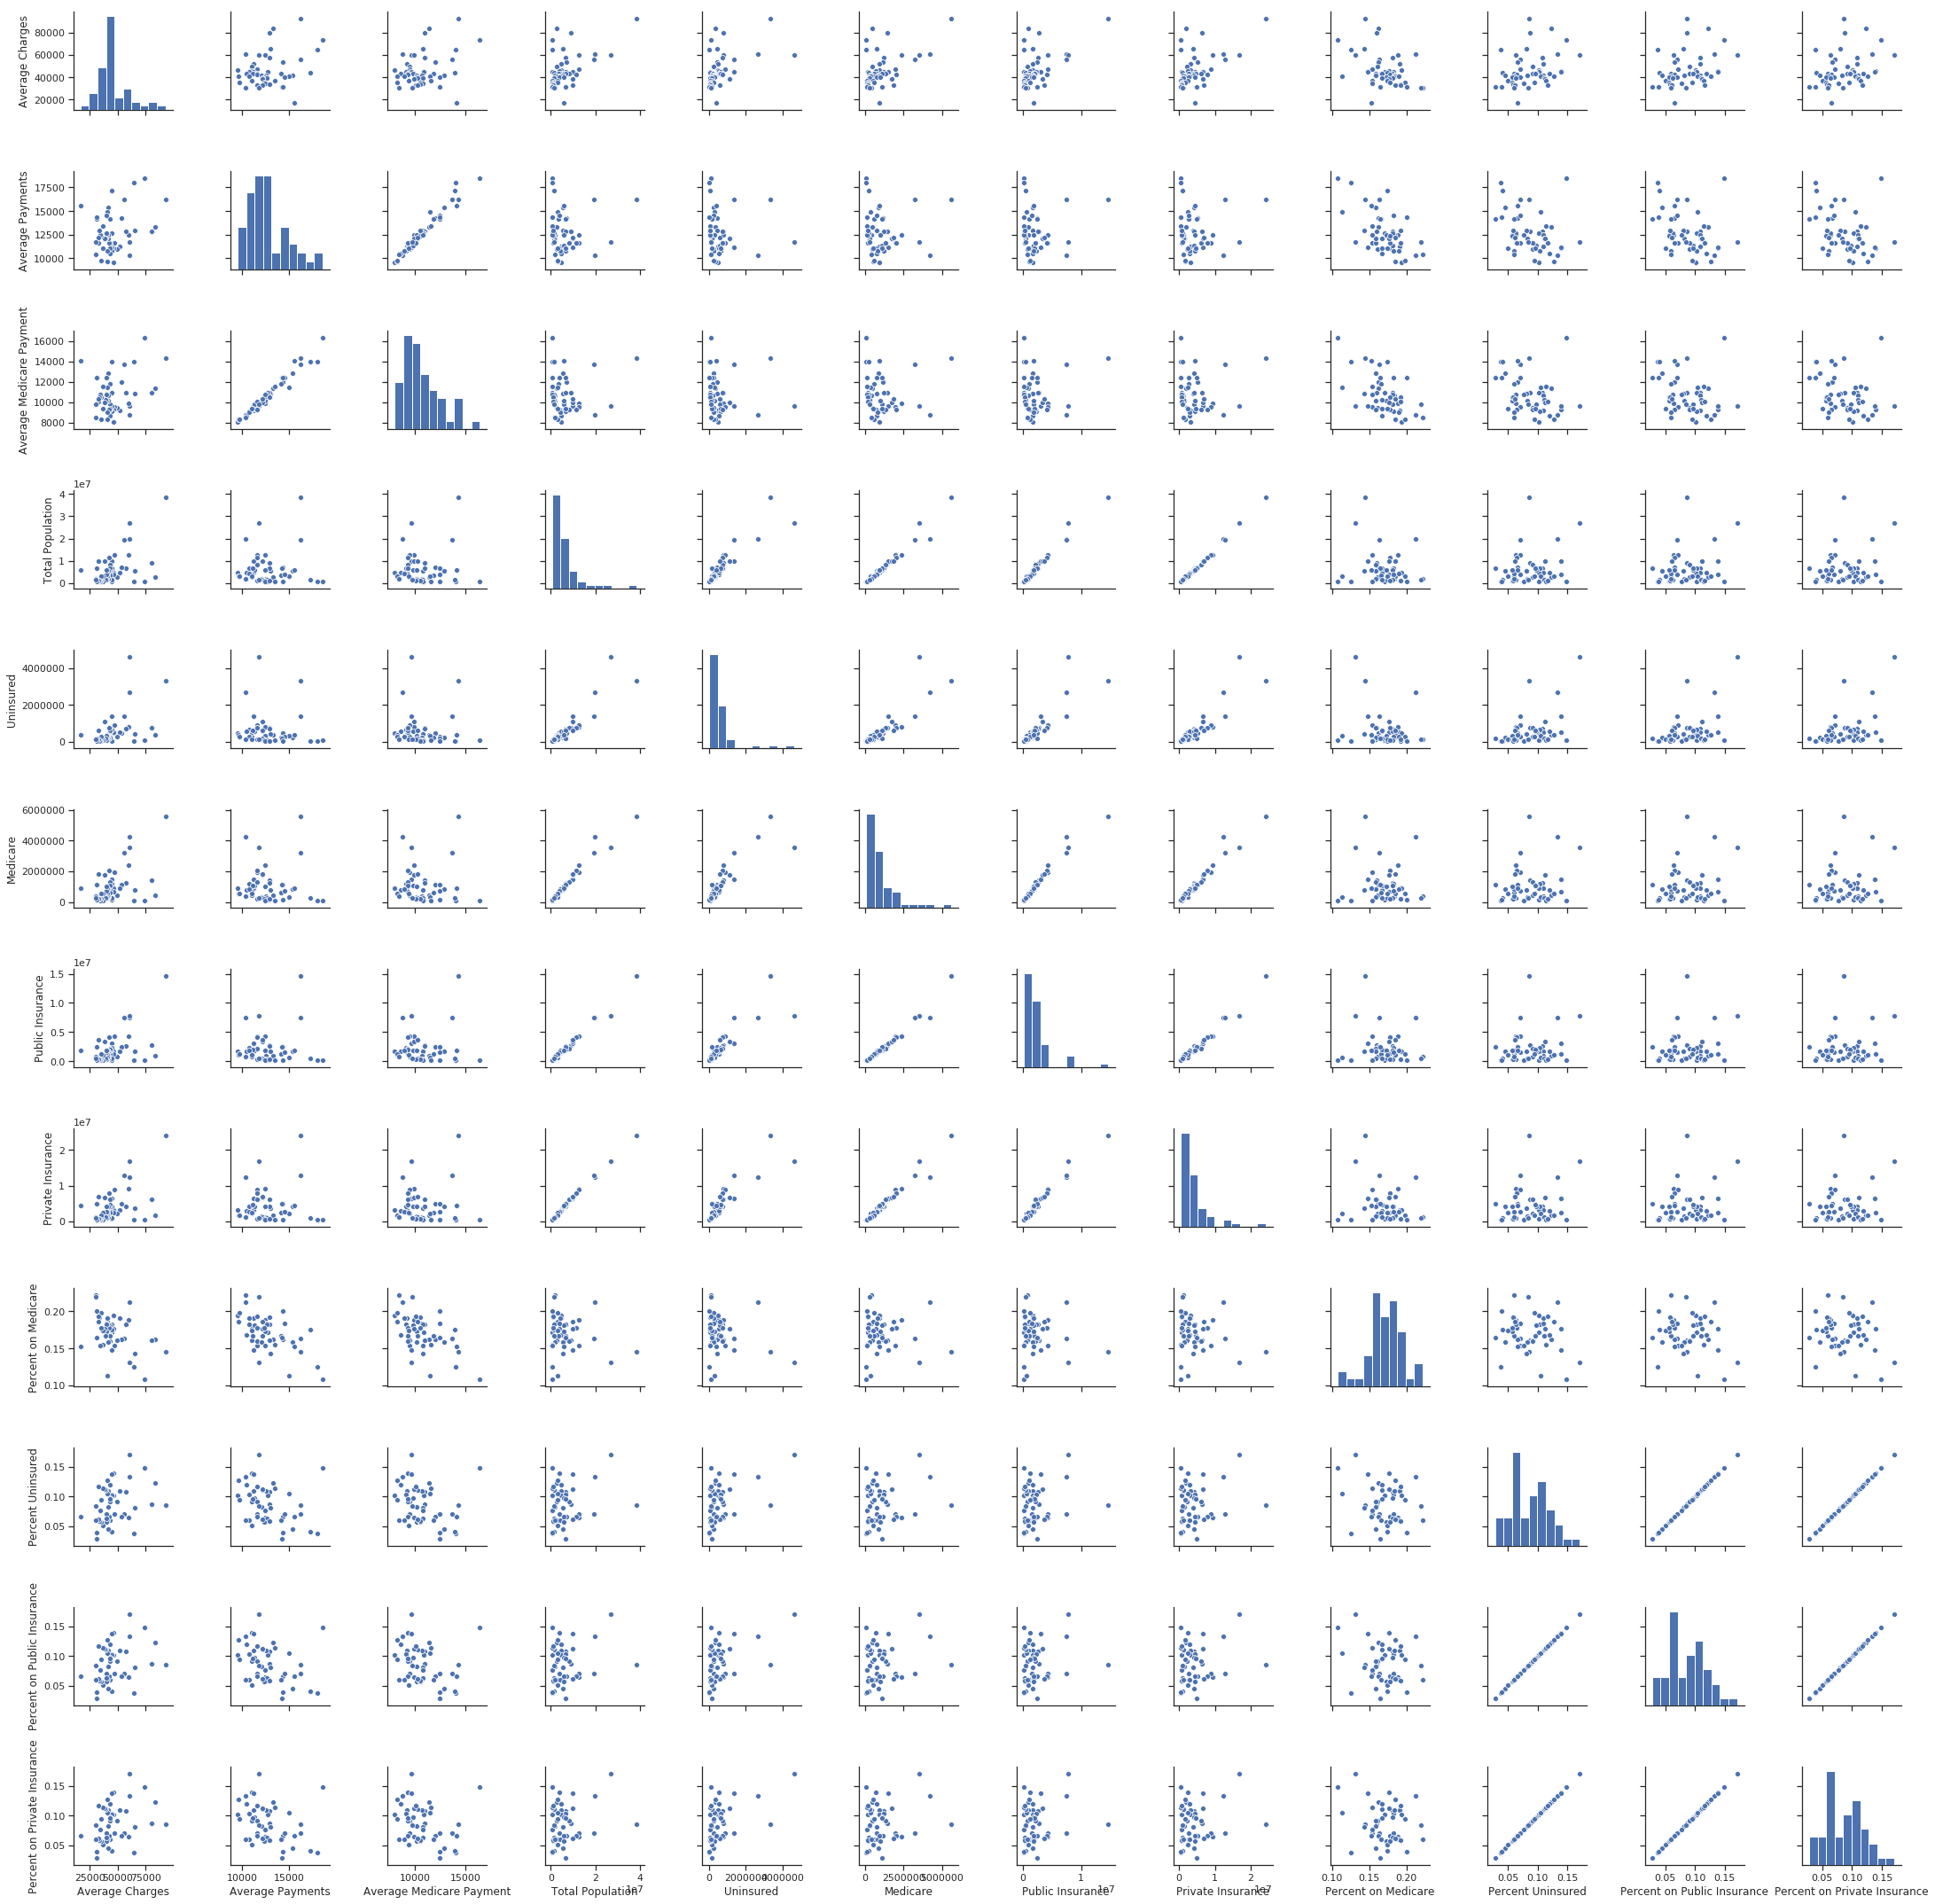

In [56]:
## Scatter Plot Matrix

## join two tables
state_subset = by_state[['Average Charges', 'Average Payments']]
ca_only = inp

joined_data = pd.merge(state_subset, state_insurances, right_index=True, left_index=True)
joined_data

import seaborn as sns
sns.set(style="ticks")

sns.pairplot(joined_data)

<a id="sec5"></a>

### 2.1 Most Common Procedure: Septicemia/Sepsis
---

Ordering by Total Discharges shows that Septicemia and Major Joint Replacement are the most common procedures. The DRG Definitions for Heart Failure and Shock or Simple Pneumonia reveal some quirks. 
The same diagnosis is separated into different categories based on time duration (i.e. >96, 96+ Hours) and additional codes as follows:
- W MCC (with major complication or co-morbidity)
- W/O MCC (with major complication or co-morbidity)
- W CC (with complication or co-morbidity)
- W/O CC (with complication or co-morbidity)

While it would make sense to combine similar DRGs, Medicare is rather strict and reimburses each DRG differently \[5\]. Therefore, I have elected to leave the diagnoses separate for this analysis. 

In [41]:
# Most Common Procedures
ordered_by_discharges = by_drg.sort_values('Total Discharges', ascending=False)
ordered_by_discharges['Total Discharges'].head(10)

DRG Definition
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC                    521358
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC    463930
291 - HEART FAILURE & SHOCK W MCC                                           221654
292 - HEART FAILURE & SHOCK W CC                                            192975
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                182443
690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                             150680
872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W/O MCC                  150151
194 - SIMPLE PNEUMONIA & PLEURISY W CC                                      148886
683 - RENAL FAILURE W CC                                                    147311
193 - SIMPLE PNEUMONIA & PLEURISY W MCC                                     144595
Name: Total Discharges, dtype: int64

In [49]:
# Bar Plot - Hover over bar to read DRG Definition
drg_by_discharges = by_drg.sort_values(by='Total Discharges', ascending=False)
drgs =  np.array(drg_by_discharges.index)
discharges = drg_by_discharges['Total Discharges']

source = ColumnDataSource(data=dict(discharges=discharges,  drgs=drgs))
                          
TOOLTIPS = [("DRG", "@drgs"), ("Count", "@discharges")]
p = figure(x_range=drgs, plot_height=400, plot_width=3000, title="Discharges for each DRG",
           toolbar_location=None, tools="hover", tooltips=TOOLTIPS)
p.vbar(x='drgs', top='discharges',width=0.7, source=source)

p.x_range.range_padding = 0.01
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.xaxis.major_label_text_font_size = '0pt'
p.yaxis[0].formatter = NumeralTickFormatter(format="0")


show(p)


<a id="sec6"></a>

###  2.2 Most Expensive Procedures: Transplants & LIfe Support
***

Ordering by Average Charges reveals that transplants (i.e. heart, lung, liver, kidneys ) are among the most expensive procedures. This makes sense due to the need for skilled doctors, special equipment, an appropriate organ donor, and potential follow-up procedures \[6\].  ECMO/TRCH/PDX , the second most expensive, is perhaps better known as life support (ECMO - Extracorporeal Membrane Oxygenation; TRACH - Bypass Trachea to Cutaneous; PDX - Respiratory Ventilation)\[8\], which generally required for severe circumstances.\[7\] Heart Transplants could be considered an outlier with an average cost just under 1 million dollars, the next most expensive being closer to half a million. The majority of diagnoses, however, are equal to or $ 200,000 U.S. Dollars. 

In [43]:
# Most Expensive Procedures
by_drg['Average Charges'].head(10)


DRG Definition
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC               957497.053889
003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.    578307.098476
927 - EXTENSIVE BURNS OR FULL THICKNESS BURNS W MV >96 HRS W SKIN GRAFT      561501.140000
007 - LUNG TRANSPLANT                                                        541050.487186
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT                        484978.004299
820 - LYMPHOMA & LEUKEMIA W MAJOR O.R. PROCEDURE W MCC                       473631.810000
749 - OTHER FEMALE REPRODUCTIVE SYSTEM O.R. PROCEDURES W CC/MCC              432594.920000
453 - COMBINED ANTERIOR/POSTERIOR SPINAL FUSION W MCC                        403442.503892
456 - SPINAL FUS EXC CERV W SPINAL CURV/MALIG/INFEC OR 9+ FUS W MCC          370565.278945
008 - SIMULTANEOUS PANCREAS/KIDNEY TRANSPLANT                                369886.419732
Name: Average Charges, dtype: float64

In [50]:
# Bar Plot - Hover over bar to see DRG Defintion

drgs =  np.array(by_drg.index)
costs = by_drg['Average Charges']

source = ColumnDataSource(data=dict(costs=costs,  drgs=drgs))
                          
TOOLTIPS = [("DRG", "@drgs") ]
p = figure(x_range=drgs, plot_height=400, plot_width=3000, title="Charges for each DRG",
           toolbar_location='above', tools=["hover", "save"], tooltips=TOOLTIPS)
p.vbar(x='drgs', top='costs',width=0.7, source=source)

p.x_range.range_padding = 0.01
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.xaxis.major_label_text_font_size = '0pt'
p.yaxis[0].formatter = NumeralTickFormatter(format="$0")


show(p)

<a id="sec7"></a>

###  2.3 Most Costly States: California, Nevada, New Jersey, Alaska, Colorado
---

While some of the most populous states are among the ones with highest charges, Alaska and Nevada, having smaller populations, are curious findings. Alaska's remoteness and lack of resources might explain the high costs. As for Nevada, a deeper look into the state policies would be required. 

In [51]:
#Choropleth

state_geo = os.path.join('us-states.json')
by_state['State Name'] = by_state.index


m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(geo_data = state_geo, 
              data = by_state,
              columns = ['State Name', 'Average Charges'],
              key_on = 'feature.properties.name',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Average Charges').add_to(m)

folium.LayerControl().add_to(m)

m

In [52]:
# Bar Plot
costs = by_state['Average Charges']
states = np.array(by_state.index)

source = ColumnDataSource(data=dict(states=states, costs=costs))
                          
tooltips= [("State", "@states")]
p = figure(x_range=states, plot_height=400, plot_width=800, title="Charges by State",
           toolbar_location=None, tools="hover", tooltips=tooltips)
p.vbar(x='states', top='costs',width=0.7, color="#e84d60", source=source)

p.x_range.range_padding = 0.01
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
#p.xaxis.major_label_text_font_size = '0pt'
p.yaxis[0].formatter = NumeralTickFormatter(format="$0")
p.xaxis.major_label_orientation = pi/4


show(p)

<a id="sec8"></a>

### 2.4 Charges v. Payments: Missing Money?
---

Plotting  Charges versus Payments reveals a significant gap. The plot appears to show that health care providers recover on average 26.49% of the total bill! Of that small 26%, Medicare pays roughly 80% on average, and the patient and other third parties covering the other 20%. This suggests missing data - how to hospitals recover the rest of the money? While it's a very intriguing question, it lies outside the scope of this analysis. 

In [68]:
percent_diff = pd.DataFrame()
percent_diff['Payment/Charges']= by_drg['Average Payments'] / by_drg['Average Charges']
percent_diff['Medicare/Charges']= by_drg['Average Medicare Payment'] / by_drg['Average Charges']
percent_diff['Medicare/Payments']= by_drg['Average Medicare Payment'] / by_drg['Average Payments']
percent_diff.describe()

,Payment/Charges,Medicare/Charges,Medicare/Payments
count,563.000000,563.000000,563.000000
mean,0.264986,0.214495,0.809529
std,0.081499,0.069994,0.071610
min,0.079937,0.062353,0.174372
25%,0.234431,0.184234,0.774006
50%,0.250206,0.206171,0.818651
75%,0.270675,0.226007,0.855049
max,0.924872,0.797219,0.988226


In [192]:
# Charges V Payments
drgs =  np.array(by_drg.index)
costs = by_drg['Average Charges']
payments = by_drg['Average Payments']

source1 = ColumnDataSource(data=dict(costs=costs,  payments=payments, drgs=drgs))
                          
tooltips= [("DRG", "@drgs"), ("Cost", "@costs"), ("Payment", "@payments")]
p1 = figure(x_range=drgs, plot_height=400, plot_width=3000, title="Charges v. Payments for each DRG",
           toolbar_location="above", tools=["hover", "save"], tooltips=tooltips)
p1.vbar(x='drgs', top='costs',width=0.7, source=source1)
p1.vbar(x='drgs', top='payments',width=0.7, color="#e84d60", source=source1)

p1.x_range.range_padding = 0.01
p1.xgrid.grid_line_color = None
p1.axis.minor_tick_line_color = None
p1.outline_line_color = None
p1.xaxis.major_label_text_font_size = '0pt'
p1.yaxis[0].formatter = NumeralTickFormatter(format="$0")


##Payments V Medicare
drg_by_payments = by_drg.sort_values(by='Average Payments', ascending=False)
drgs =  np.array(drg_by_payments.index)
payments = drg_by_payments['Average Payments']
medicare = drg_by_payments['Average Medicare Payment']

source2 = ColumnDataSource(data=dict(medicare=medicare,  payments=payments, drgs=drgs))
                          
tooltips= [("DRG", "@drgs"),  ("Total Payment", "@payments"), ("Medicare Payment", "@medicare")]
p2 = figure(x_range=drgs, plot_height=400, plot_width=3000, title="Payments v. Medicare Payments for each DRG",
           toolbar_location=None, tools="hover", tooltips=tooltips)
p2.vbar(x='drgs', top='payments',width=0.7, color="#e84d60", source=source2)
p2.vbar(x='drgs', top='medicare',width=0.7, color="#718dbf", source=source2)

p2.x_range.range_padding = 0.01
p2.xgrid.grid_line_color = None
p2.axis.minor_tick_line_color = None
p2.outline_line_color = None
p2.xaxis.major_label_text_font_size = '0pt'
p2.yaxis[0].formatter = NumeralTickFormatter(format="$0")

show(column(p1, p2))

<a id="sec9"></a>

### 2.5 Percent of People on Medicare by State
---

It appears that the eastern half of the United States has a higher percentage of people on Medicare, however, keep in the mind the scale only ranges from 11% and 22% of a state's total population. It will be necessary to scale the aggregated state data before comparing the percentages of people on Medicare against the charges.

In [141]:
state_geo = os.path.join('us-states.json')

state_insurances['State Name'] = state_insurances.index

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(geo_data = state_geo, 
              data = state_insurances,
              columns = ['State Name' , 'Percent on Medicare'],
              key_on = 'feature.properties.name',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Percent on Medicare').add_to(m)

folium.LayerControl().add_to(m)

m

<a id="sec10"></a>

## 3. Modeling and Analysis 
---

<a id="sec11"></a>

### 3.1 KMeans Clustering on DRG's 
---

Before modeling the data, we need to check the normality and skew of the columns. Histograms of the grouped DRG data columns reveal an extreme right-skew. Performing a k-means clustering on unscaled data yields erroneous results. The Silhoutte score is very high, and yet the first two PCA components capture a marginal amount of the variance! Since we want to retain all of our data, including the extremely pricey heart transplant, this table seems a good candidate for log transformation.

In [7]:
#histograms extremely right skewed

p1 = figure( plot_height=250, plot_width=250, title="Charges")
hist, edges = histogram(by_drg['Average Charges'], density=True, bins=100)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p2 = figure( plot_height=250, plot_width=250, title="Payments")
hist, edges = histogram(by_drg['Average Payments'], density=True, bins=100)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p3 = figure( plot_height=250, plot_width=250, title="Medicare Payments")
hist, edges = histogram(by_drg['Average Medicare Payment'], density=True, bins=100)
p3.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p4 = figure( plot_height=250, plot_width=250, title="Discharges")
hist, edges = histogram(by_drg['Total Discharges'], density=True, bins=50)
p4.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

show(row(p1, p2, p3, p4))



In [8]:
#Run K Means on DRG Data without Scaling = Bad Results

kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(by_drg)
clusterIDs = kmeansModel.labels_


# Visualise on PCA Plot
pca = PCA(n_components=2)
pca.fit(by_drg)
pca_pairs = pca.transform(by_drg)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(by_drg[clusterIDs==0].index),
     cost=np.array(by_drg[clusterIDs==0]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==0]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==0]['Total Discharges'])))

clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(by_drg[clusterIDs==1].index),
     cost=np.array(by_drg[clusterIDs==1]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==1]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==1]['Total Discharges'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     drg=np.array(by_drg[clusterIDs==2].index),
     cost=np.array(by_drg[clusterIDs==2]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==2]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==2]['Total Discharges'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     drg=np.array(by_drg[clusterIDs==3].index),
     cost=np.array(by_drg[clusterIDs==3]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==3]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==3]['Total Discharges'])))              

TOOLTIPS = [("DRG", "@drg"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title=None, toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)


print("Silhouette Score: ", metrics.silhouette_score(by_drg, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.8168446076581466
PCA Explained Variance Ratio:  [9.99630978e-01 3.18208499e-04]


In [9]:
# log transformation on group (don't want to discard outliers) shifts histograms closer to normality
by_drg_scaled = by_drg[['Average Charges', 'Average Payments', 'Average Medicare Payment', 'Total Discharges']].apply(np.log)

p1 = figure( plot_height=250, plot_width=250, title="Charges")
hist, edges = histogram(by_drg_scaled['Average Charges'], density=True, bins=100)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p2 = figure( plot_height=250, plot_width=250, title="Payments")
hist, edges = histogram(by_drg_scaled['Average Payments'], density=True, bins=100)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p3 = figure( plot_height=250, plot_width=250, title="Medicare Payments")
hist, edges = histogram(by_drg_scaled['Average Medicare Payment'], density=True, bins=100)
p3.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p4 = figure( plot_height=250, plot_width=250, title="Discharges")
hist, edges = histogram(by_drg_scaled['Total Discharges'], density=True, bins=50)
p4.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

show(row(p1, p2, p3, p4))

Running k-means on the scaled data produces more accurate results. The spread of the clusters is more visible, and the first two PCA components can account for almost 98% of the variance of the data. The silhouette score is rather low at 0.36, but more accurately reflects the lack of well-separated clusters. All the data are grouped quite close together on the plot.

In [10]:
# KMeans on Scaled DRG data

kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(by_drg_scaled)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(by_drg_scaled)
pca_pairs = pca.transform(by_drg_scaled)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(by_drg[clusterIDs==0].index),
     cost=np.array(by_drg[clusterIDs==0]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==0]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==0]['Total Discharges'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(by_drg[clusterIDs==1].index),
     cost=np.array(by_drg[clusterIDs==1]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==1]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==1]['Total Discharges'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     drg=np.array(by_drg[clusterIDs==2].index),
     cost=np.array(by_drg[clusterIDs==2]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==2]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==2]['Total Discharges'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     drg=np.array(by_drg[clusterIDs==3].index),
     cost=np.array(by_drg[clusterIDs==3]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==3]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==3]['Total Discharges'])))   
                                                              

TOOLTIPS = [("DRG", "@drg"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=4", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.35831911510788694
PCA Explained Variance Ratio:  [0.80863688 0.1859832 ]


Let us try to improve the model by adjusting the value of k. Doing a simple search over the range of  k= 2 to k= 9 yields k=2 with the highest Silhouette score, although the magnitude of improvement is rather small. At k=2 the Silhouette score is about 0.447 compared to 0.362 at k=4.

In [11]:
# Finding the best k in range 2 -9 
sil_scores = {}

for n in range(2,10):
    kmeansModel = KMeans(init='random', n_clusters=n, n_init=10)
    kmeansModel.fit_predict(by_drg_scaled)
    clusterIDs = kmeansModel.labels_
    score = metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean')
    sil_scores[n]=(score)

    
print("Silhouette Scores")
pp.pprint(sil_scores)



Silhouette Scores
{2: 0.4775714725288577,
 3: 0.3771059110130793,
 4: 0.36298851880791305,
 5: 0.35131997604888643,
 6: 0.3641222202797719,
 7: 0.3645035480872405,
 8: 0.35998926484963867,
 9: 0.35025680823936217}


After running k-means again with k=2, a quick visual inspection (using tooltip hover to get a summary of each data point) seems to show that data points on the left have a smaller number of discharges (<1000) and DRGs on right clusters have a higher number of discharges (>1000). This is a very broad division.

In [12]:
## KMeans with 2 Clusters - Hover to read DRG, Cost/Payments/Charges

kmeansModel = KMeans(init='random', n_clusters=2, n_init=10)
kmeansModel.fit_predict(by_drg_scaled)
clusterIDs = kmeansModel.labels_

pca = PCA(n_components=2)
pca.fit(by_drg_scaled)
pca_pairs = pca.transform(by_drg_scaled)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(by_drg[clusterIDs==0].index),
     cost=np.array(by_drg[clusterIDs==0]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==0]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==0]['Total Discharges'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(by_drg[clusterIDs==1].index),
     cost=np.array(by_drg[clusterIDs==1]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==1]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==1]['Total Discharges'])))

                                                              

TOOLTIPS = [("DRG", "@drg"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=2", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=10, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=10, color="crimson")

p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.4775714725288577
PCA Explained Variance Ratio:  [0.80863688 0.1859832 ]


In [33]:
### Fix Number of Discharges

##  Grouping Data by DRG & by State for analysis and eventual clustering

# To avoid aggregrating the mean of means, first recover total sum of charges/payments for each row
inpatient_charges['Total Charges'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Covered Charges']
inpatient_charges['Total Payments'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Total Payments']
inpatient_charges['Total Medicare Payments'] = inpatient_charges['Total Discharges'] * inpatient_charges['Average Medicare Payments']
inpatient_charges['Count Discharges'] = inpatient_charges['Total Discharges']


#group by DRG, take sums
by_drg = inpatient_charges.groupby(['DRG Definition']).agg({ 'Total Discharges':'sum',
                                                             'Count Discharges':'count',
                                                             'Total Charges': 'sum',
                                                             'Total Payments':'sum',
                                                             'Total Medicare Payments': 'sum' })

# #calcuate new averages
by_drg['Average Charges'] = by_drg['Total Charges']/by_drg['Total Discharges']
by_drg['Average Payments'] = by_drg['Total Payments']/by_drg['Total Discharges']
by_drg['Average Medicare Payment'] = by_drg['Total Medicare Payments']/by_drg['Total Discharges']
by_drg['Average Discharges'] = by_drg['Total Discharges'] / by_drg['Count Discharges']


by_drg_scaled = by_drg[['Average Charges', 'Average Payments', 'Average Medicare Payment', 'Average Discharges']].apply(np.log)
by_drg_scaled.head()

# by_drg = by_drg.sort_values(by='Average Charges', ascending=False)


# # group by state, take sums
# by_state = inpatient_charges.groupby(['State']).agg({ 'Total Discharges':'sum',
#                                                          'Total Charges': 'sum',
#                                                          'Total Payments':'sum',
#                                                          'Total Medicare Payments': 'sum' })

# #calcuate new averages
# by_state['Average Charges'] = by_state['Total Charges']/by_state['Total Discharges']
# by_state['Average Payments'] = by_state['Total Payments']/by_state['Total Discharges']
# by_state['Average Medicare Payment'] = by_state['Total Medicare Payments']/by_state['Total Discharges']

# by_state = by_state.sort_values(by='Average Charges', ascending=False)

,Average Charges,Average Payments,Average Medicare Payment,Average Discharges
DRG Definition,,,,
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,13.772078,12.463133,12.304610,3.094109
"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",13.267860,11.896834,11.779170,3.316996
"004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W/O MAJ O.R.",12.703653,11.298595,11.188638,3.016106
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,13.091859,11.731995,11.494832,2.939852
006 - LIVER TRANSPLANT W/O MCC,12.350668,10.772366,10.397716,2.590267


In [37]:
# KMeans on Scaled DRG data

kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(by_drg_scaled)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(by_drg_scaled)
pca_pairs = pca.transform(by_drg_scaled)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(by_drg[clusterIDs==0].index),
     cost=np.array(by_drg[clusterIDs==0]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==0]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==0]['Average Discharges'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(by_drg[clusterIDs==1].index),
     cost=np.array(by_drg[clusterIDs==1]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==1]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==1]['Average Discharges'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     drg=np.array(by_drg[clusterIDs==2].index),
     cost=np.array(by_drg[clusterIDs==2]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==2]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==2]['Average Discharges'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     drg=np.array(by_drg[clusterIDs==3].index),
     cost=np.array(by_drg[clusterIDs==3]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==3]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==3]['Average Discharges'])))   
                                                              

TOOLTIPS = [("DRG", "@drg"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=4", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.3819854943080289
PCA Explained Variance Ratio:  [0.87211363 0.10300716]


In [35]:
# Finding the best k in range 2 -9 
sil_scores = {}

for n in range(2,10):
    kmeansModel = KMeans(init='random', n_clusters=n, n_init=10)
    kmeansModel.fit_predict(by_drg_scaled)
    clusterIDs = kmeansModel.labels_
    score = metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean')
    sil_scores[n]=(score)

    
print("Silhouette Scores")
pp.pprint(sil_scores)

Silhouette Scores
{2: 0.5104685765247966,
 3: 0.4243495403022448,
 4: 0.3819854943080289,
 5: 0.4070221198258076,
 6: 0.38161952617312306,
 7: 0.3433722084287964,
 8: 0.3434844171246083,
 9: 0.31529915680548937}


In [36]:
## KMeans with 2 Clusters - Hover to read DRG, Cost/Payments/Charges

kmeansModel = KMeans(init='random', n_clusters=2, n_init=10)
kmeansModel.fit_predict(by_drg_scaled)
clusterIDs = kmeansModel.labels_

pca = PCA(n_components=2)
pca.fit(by_drg_scaled)
pca_pairs = pca.transform(by_drg_scaled)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(by_drg[clusterIDs==0].index),
     cost=np.array(by_drg[clusterIDs==0]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==0]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==0]['Total Discharges'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(by_drg[clusterIDs==1].index),
     cost=np.array(by_drg[clusterIDs==1]['Average Charges']) ,
     payment=np.array(by_drg[clusterIDs==1]['Average Payments']),
     discharges=np.array(by_drg[clusterIDs==1]['Total Discharges'])))

                                                              

TOOLTIPS = [("DRG", "@drg"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=2", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=10, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=10, color="crimson")

p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(by_drg_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.5104685765247966
PCA Explained Variance Ratio:  [0.87211363 0.10300716]


<a id="sec12"></a>

## 3.2 Assessing Correlation: Percent on Medicare and Average Charges by State
---

Here I want to see if the proportion of people on Medicare is correlated to the Average Charges for that state. 
A simple null hypothesis is that there is no significant correlation.

In [176]:
# merge medicare cost/payment with percentages of people with Medicare insurance
costs_insurances = pd.merge(by_state, state_insurances, left_index=True, right_index=True)
costs_insurances.drop(columns=['State Name_x',
                               'State Name_y',
                               'State',
                               'Total Population',
                               'Medicare',
                               'Uninsured',
                               'Public Insurance',
                               'Private Insurance'], inplace=True)
costs_insurances.head()

,Total Discharges,Total Charges,Total Payments,Total Medicare Payments,Average Charges,Average Payments,Average Medicare Payment,Percent on Medicare,Percent Uninsured,Percent on Public Insurance,Percent on Private Insurance
State,,,,,,,,,,,
California,503269,4.666635e+10,8.154392e+09,7.195634e+09,92726.447013,16202.850641,14297.788762,0.144709,0.085821,0.085821,0.085821
Nevada,49853,4.184796e+09,6.639318e+08,5.692880e+08,83942.720681,13317.789519,11419.332209,0.162465,0.122899,0.122899,0.122899
New Jersey,265786,2.127858e+10,3.424230e+09,2.915478e+09,80059.060888,12883.408961,10969.269132,0.160452,0.087119,0.087119,0.087119
Alaska,7014,5.180097e+08,1.297953e+08,1.147645e+08,73853.672169,18505.172409,16362.207136,0.107994,0.148668,0.148668,0.148668
Colorado,70133,4.583198e+09,9.090320e+08,7.587394e+08,65350.097235,12961.543822,10818.578289,0.143283,0.080678,0.080678,0.080678


We know from earlier that the charges, payments, and discharges columns are heavily right skewed. What about the percentages? Visualizing that column on a QQ-plot and histogram reveals a more short-tail, symmetric distribution. 

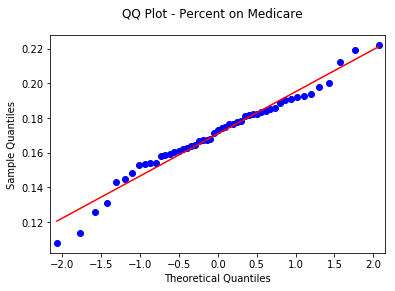

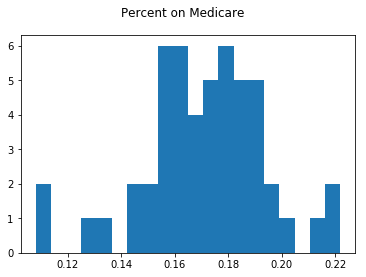

In [170]:
# check normality of Percent on Medicare
col1 = "Percent on Medicare" 


fig = smdl.qqplot(state_insurances[col1], stats.norm, line = 'r')
plt.suptitle('QQ Plot - Percent on Medicare')
plt.show()


plt.hist(state_insurances[col1], 20)
plt.suptitle(col1)
plt.show()

Both the Spearman and Pearson correlation coefficients are around -0.40, suggesting a slight negative correlation.
As for the significance, both p-values are very low, p < 0.004, indicating strong evidence for rejecting the null hypothesis.

Correlation Pearson:  -0.4058587370022682 p-value:  0.003127898541645666
Correlation Spearman:  -0.38932126696832575 p-value:  0.004746859858689049


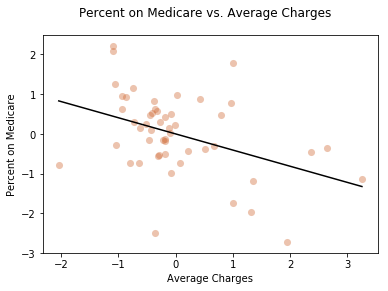

In [183]:
import warnings
warnings.filterwarnings('ignore')


#normalize
col_names = costs_insurances.columns
idx = costs_insurances.index
scaler = StandardScaler()
costs_insurances_scaled = scaler.fit_transform(costs_insurances)
costs_insurances_scaled = pd.DataFrame(costs_insurances_scaled, columns=col_names, index=idx)
costs_insurances_scaled


# correlation columns
x = np.array(costs_insurances_scaled['Average Charges'])
y = np.array(costs_insurances_scaled['Percent on Medicare'])

# Pearson correlation
corrPearson, pVal1 = stats.pearsonr(x, y)
print ("Correlation Pearson: ", corrPearson, "p-value: ", pVal1)

# Spearman crrelation
corrSpearman, pVal2 = stats.spearmanr(x, y)
print ("Correlation Spearman: ", corrSpearman, "p-value: ", pVal2)


# Plot variables
plt.figure(1)
plt.suptitle('Percent on Medicare vs. Average Charges')
plt.ylabel('Percent on Medicare')
plt.xlabel('Average Charges')
plt.scatter(x,y, c = "#D06B36", s = 50, alpha = 0.4, linewidth='0')

# Plot Regression Line
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
evaluatedLine = np.polyval([slope, intercept], x)
plt.plot(x, evaluatedLine, 'k-')

plt.show()




<a id="sec13"></a>

# 3.3 KMeans Clustering on US States
---

First, I ran k-means with k=4 on the data aggregated by state. A brief visual inspection (using the hover tool) reveal the most populous states - California, New York, Florida, Pennsylvia, Illinois, New Jersey - grouped together in the right most cluster, but some overlap among the other clusters. The silhouette score is a low 0.255 and the first two PCA components only cover about 70% of the variance.

In [199]:
# KMeans on State Data
kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(costs_insurances_scaled)
clusterIDs = kmeansModel.labels_



pca = PCA(n_components=2)
pca.fit(costs_insurances_scaled)
pca_pairs = pca.transform(costs_insurances_scaled)

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==0].index)))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==1].index)))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==2].index)))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==3].index)))
                                                       
                                                    
                         
                         

TOOLTIPS = [("State", "@state") ]
p = figure(plot_width=900, plot_height=600, title=None, toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=10, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=10, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=10, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=10, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(costs_insurances_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.21260487395025351
PCA Explained Variance Ratio:  [0.4033194  0.29229048]


Again, searching for an optimal k value using silhouette scores yields k=2 and Silhouette score=0.393. Despite this, the most populous states are again in the rightmost cluster, and the remaining states comprising the other cluster. This may indicate an error during data transformation and scaling steps, since effects of population size have not been mitigated.

In [184]:
# Finding the best k in range 2 -9 

sil_scores = {}

for n in range(2,10):
    kmeansModel = KMeans(init='random', n_clusters=n, n_init=10)
    kmeansModel.fit_predict(costs_insurances_scaled)
    clusterIDs = kmeansModel.labels_
    score = metrics.silhouette_score(costs_insurances_scaled, clusterIDs, metric='euclidean')
    sil_scores[n]=(score)


print("Silhouette Scores")
pp.pprint(sil_scores)


Silhouette Scores
{2: 0.39331507247177006,
 3: 0.2679057628953906,
 4: 0.2690314973275213,
 5: 0.2689953752932344,
 6: 0.20189811990882553,
 7: 0.21782992071412544,
 8: 0.21213759809896024,
 9: 0.24027011446423308}


In [198]:
# KMeans on State Data
kmeansModel = KMeans(init='random', n_clusters=2, n_init=10)
kmeansModel.fit_predict(costs_insurances_scaled)
clusterIDs = kmeansModel.labels_



pca = PCA(n_components=2)
pca.fit(costs_insurances_scaled)
pca_pairs = pca.transform(costs_insurances_scaled)

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==0].index),
     cost=np.array(costs_insurances_scaled[clusterIDs==1]['Average Charges']) ,
     payment=np.array(costs_insurances_scaled[clusterIDs==1]['Average Payments']),
     discharges=np.array(costs_insurances_scaled[clusterIDs==1]['Total Discharges'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     state=np.array(costs_insurances_scaled[clusterIDs==1].index),
     cost=np.array(costs_insurances_scaled[clusterIDs==1]['Average Charges']) ,
     payment=np.array(costs_insurances_scaled[clusterIDs==1]['Average Payments']),
     discharges=np.array(costs_insurances_scaled[clusterIDs==1]['Total Discharges'])))

                                                       
                                                

TOOLTIPS = [("State", "@state"), ("Cost", "@cost"), ("Payment", "@payment"),("Discharges", "@discharges") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=2", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=10, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=10, color="navy")

p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(costs_insurances_scaled, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)


Silhouette Score:  0.39331507247177006
PCA Explained Variance Ratio:  [0.4033194  0.29229048]


<a id="sec14"></a>

## 4. Reflections
---

While the exploratory data analysis revealed interesting insights into the data set, clustering did not provide further insights on the structure of the data. Silhouette scores were quite low, with the best scores (only marginally) achieved with only two clusters. This limits potential analysis to broad generalizations. For instance, the k-means clustering with k=2 of the DRG data merely partitioned DRGs into more numerous and less numerous discharges. The results were even less satisfactory on state data, simply grouping the most populous states together.

I believe that trying to find structure through clustering on a statewide level and among 563 unique DRGs was likely too broad a scope and that a more granular analysis is needed. The wide range of the 536 DRGs data, from million dollar transplants to treatments in the low thousands, likely obscured smaller differences among DRGs. Partitioning the DRGs into similar groups and clustering on each subset may be better to distinguish the diagnoses. Additionally, it may be more fruitful to examine Medicare charge data at a county or zip code level. 

On a positive note, the correlation coefficients and p-values made a case for rejecting the null hypothesis stating no significant correlation between the medical charges and the percentage of people on Medicare. At least this means researchers can consider medical charges as among one of many factors when it comes into improving health insurance coverage across the United States.

<a id="sec15"></a>

## 5. References
---

\[1\]  Centers for Medicare, “Inpatient Charge Data, FY2015, Comma Separated Values (CSV) version.” 01-Mar-2018. Available: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient2015.html 

\[2\] The Centers for Medicare and Medicaid Services, and Office of Enterprise Data and Analytics, “Medicare Fee-For Service Provider Utilization & Payment Data Inpatient Public Use File: A Methodological Overview.” 19-Jul-2018. Available: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Inpatient_Methodology.pdf

\[3\] Research Data Assistance Center, “MEDPAR DRG Price Amount,” University Of Minnesota, School Of Public Health, Health Policy & Management. Available: https://www.resdac.org/cms-data/variables/medpar-drg-price-amount

\[4\] U.S. Census Bureau, “HIC-4. Health Insurance Coverage Status and Type of Coverage by State--All Persons: 2008 to 2017.” Available: https://www.census.gov/data/tables/time-series/demo/health-insurance/historical-series/hic.html 

\[5\] Boston Scientific, “Importance of Documentation and the Impact on MS-DRG Assignment- WATCHMAN™ Left Atrial Appendage Closure Device.” 30-Sep-2015. \[Online\] Available: https://www.bostonscientific.com/content/dam/bostonscientific/Reimbursement/RhythmManagement/WATCHMAN%E2%84%A2/236119-AB%20WM_Documentation_MCC%20Guide_FINAL.pdf/

\[6\] C. Bradley, “Top 10 Most Expensive Medical Procedures,” Investopedia, 18-Mar-2010. \[Online\]. Available: 
https://www.investopedia.com/financial-edge/0310/top-10-most-expensive-medical-procedures.aspx. \[Accessed: 16-Dec-2018\].

\[7\] American Thoracic Society, “What is ECMO?,” 2016. Available: https://www.thoracic.org/patients/patient-resources/resources/what-is-ecmo.pdf

\[8\] Centers for Medicare & Medicaid Services, “Pre-MDC ECMO or Tracheostomy with MV 96+ Hours or PDX Except Face, Mouth and Neck,” Draft ICD-10-CM/PCS MS-DRGv28 Definitions Manual. \[Online\]. Available: https://www.cms.gov/icd10manual/fullcode_cms/P0040.html. \[Accessed: 15-Dec-2018\].